In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import datetime

import seaborn as sns
color = sns.color_palette()
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from collections import Counter

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder,PolynomialFeatures,MinMaxScaler,minmax_scale

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor, Pool

from  itertools import combinations

from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import lightgbm as lgb

from sklearn.svm import SVR

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None

In [4]:
#tickets132 = pd.read_csv('tickets/tickets_2013_02.csv', sep=';',encoding ='utf8')

In [2]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        print(column)
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index = True, left_index = True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df



In [61]:
df_train = load_df()
df_test = load_df('test.csv')

device
geoNetwork
totals
trafficSource
Loaded train.csv. Shape: (903653, 55)
device
geoNetwork
totals
trafficSource
Loaded test.csv. Shape: (804684, 53)


In [2]:
%%time
df_train.to_csv("train-flattened.csv", index=False)
df_test.to_csv("test-flattened.csv", index=False)

NameError: name 'df_train' is not defined

In [2]:
df_train = pd.read_csv('train-flattened.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv('test-flattened.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning:

Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
Id = df_train['fullVisitorId']
df_train.drop(['fullVisitorId','socialEngagementType','sessionId','visitId'],axis=1,inplace=True)
df_train.drop(['totals.bounces','totals.newVisits','totals.visits '], axis=1 ,inplace=True)

In [51]:
df_train['totals.pageviews']=df_train['totals.pageviews'].fillna(0)
df_train['totals.transactionRevenue']=df_train['totals.transactionRevenue'].fillna(0)

#df_train['trafficSource.adwordsClickInfo.adNetworkType']=df_train['trafficSource.adwordsClickInfo.adNetworkType'].fillna("Other")

In [15]:
#df_train.loc[df_train['totals.transactionRevenue'].isnull(),'totals.transactionRevenue']='0'
df_train['totals.transactionRevenue']=df_train['totals.transactionRevenue'].astype('int64')

In [39]:
df_train.head(10)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,month,day,weekday,start_hour,day_seconds,month_seconds,week_seconds,year_seconds,month-day,month-weekday,month-start_hour,day-weekday,day-start_hour,weekday-start_hour,month-day-weekday,month-day-start_hour,month-weekday-start_hour,day-weekday-start_hour
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,9,2,4,15,55985,228785,487985,21310385,9-2,9-4,9-15,2-4,2-15,4-15,9-2-4,9-2-15,9-4-15,2-4-15
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,9,2,4,5,19347,278547,537747,21360147,9-2,9-4,9-5,2-4,2-5,4-5,9-2-4,9-2-5,9-4-5,2-4-5
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,9,2,4,1,4586,263786,522986,21345386,9-2,9-4,9-1,2-4,2-1,4-1,9-2-4,9-2-1,9-4-1,2-4-1
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google,9,2,4,5,20413,279613,538813,21361213,9-2,9-4,9-5,2-4,2-5,4-5,9-2-4,9-2-5,9-4-5,2-4-5
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google,9,2,4,13,48200,221000,480200,21302600,9-2,9-4,9-13,2-4,2-13,4-13,9-2-4,9-2-13,9-4-13,2-4-13
5,Organic Search,2016-09-02,2938943183656635653,1472807194,1,1472807194,Chrome,desktop,False,Windows,not available in demo dataset,Europe,Italy,not available in demo dataset,fastwebnet.it,not available in demo dataset,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,9,2,4,9,32794,205594,464794,21287194,9-2,9-4,9-9,2-4,2-9,4-9,9-2-4,9-2-9,9-4-9,2-4-9
6,Organic Search,2016-09-02,1905672039242460897,1472817241,1,1472817241,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Pakistan,not available in demo dataset,unknown.unknown,not available in demo dataset,Southern Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,9,2,4,11,42841,215641,474841,21297241,9-2,9-4,9-11,2-4,2-11,4-11,9-2-4,9-2-11,9-4-11,2-4-11
7,Organic Search,2016-09-02,537222803633850821,1472812602,1,1472812602,Chrome,desktop,False,Windows,Brisbane,Oceania,Australia,(not set),bigpond.net.au,Queensland,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not 

In [172]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null object
fullVisitorId                                   903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country                        

pandas.core.series.Series

In [47]:
other_browsers=df_train['device.browser'].value_counts()[df_train['device.browser'].value_counts()<400].index
df_train['device.browser']=df_train['device.browser'].replace(other_browsers,'Other')

In [63]:
df_train[df_train['totals.transactionRevenue'] > 0].groupby(['trafficSource.adwordsClickInfo.adNetworkType'])['totals.transactionRevenue'].count()

trafficSource.adwordsClickInfo.adNetworkType
Google Search      454
Other            11061
Name: totals.transactionRevenue, dtype: int64

In [17]:
df_train.drop(const_cols,axis=1,inplace=True)

In [61]:
df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].astype('float')
gdf = df_train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

In [62]:
nzi = pd.notnull(df_train['totals.transactionRevenue']).sum()
nzr = (gdf['totals.transactionRevenue']>0).sum()
print('Number of instances in train set with non-zero revenue : ',nzi,' and ratio is : ', nzi/df_train.shape[0])
print('Number of unique customers with non-zero revenue : ',nzr,' and ratio is : ', nzr/gdf.shape[0])


Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996  and ratio is :  0.013996726255903731


In [63]:
print('Number of unique visitors in train set: ', df_train['fullVisitorId'].nunique(), ' out of rows: ',df_train.shape[0])
print('Number of unique visitors in test set:', df_test.fullVisitorId.nunique(), 'out of :' , df_test.shape[0] )
print("Number of common visitors in train and test set : ", len(set(df_train.fullVisitorId.unique()).intersection(set(df_test.fullVisitorId.unique())) ))

Number of unique visitors in train set:  714167  out of rows:  903653
Number of unique visitors in test set: 617242 out of : 804684
Number of common visitors in train and test set :  7679


In [3]:
const_cols = [c for c in df_train.columns if df_train[c].nunique(dropna=False)==1]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [4]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend = False,
        orientation = 'h',
        marker=dict(color=color)
    )
    return trace

In [32]:
#Device Browser
cnt_srs = df_train.groupby('device.browser')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace1 = horizontal_bar_chart(cnt_srs['count'].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(10), 'rgba(50, 171, 96, 0.6)')
#Device Category
cnt_srs = df_train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace4= horizontal_bar_chart(cnt_srs['count'].head(10), 'rgba(71, 58,131, 0.8)')
trace5= horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'rgba(71, 58,131, 0.8)')
trace6= horizontal_bar_chart(cnt_srs['mean'].head(10), 'rgba(71, 58,131, 0.8)')
#Operating system
cnt_srs = df_train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace7= horizontal_bar_chart(cnt_srs['count'].head(10), 'rgba(246, 78, 139, 0.6)')
trace8= horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'rgba(246, 78, 139, 0.6)')
trace9= horizontal_bar_chart(cnt_srs['mean'].head(10), 'rgba(246, 78, 139, 0.6)')

#Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04,
                         subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title='Device Plots')
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



SyntaxError: invalid syntax (<ipython-input-45-04c4a22c9184>, line 13)

In [168]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(color=color)
    )
    return trace

df_train['date'] = df_train['date'].apply(lambda x: datetime.date(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:])))
cnt_srs = df_train.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]

cnt_srs = cnt_srs.sort_index()
trace1 = scatter_plot(cnt_srs['count'], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')


This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [66]:
df_test['date'] = df_test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = df_test.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

Geographic Information:

In [71]:
#Continent
cnt_srs = df_train.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace1 = horizontal_bar_chart(cnt_srs['count'].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(10), 'rgba(50, 171, 96, 0.6)')
#Sub-continent
cnt_srs = df_train.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace4= horizontal_bar_chart(cnt_srs['count'], 'rgba(71, 58,131, 0.8)')
trace5= horizontal_bar_chart(cnt_srs['count of non-zero revenue'], 'rgba(71, 58,131, 0.8)')
trace6= horizontal_bar_chart(cnt_srs['mean'], 'rgba(71, 58,131, 0.8)')
#Network domain
cnt_srs = df_train.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace7= horizontal_bar_chart(cnt_srs['count'].head(10), 'rgba(246, 78, 139, 0.6)')
trace8= horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'rgba(246, 78, 139, 0.6)')
trace9= horizontal_bar_chart(cnt_srs['mean'].head(10), 'rgba(246, 78, 139, 0.6)')

#Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04,
                         subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title='Geography Plots')
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



Traffic Source:

In [73]:
#traffic source
cnt_srs = df_train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace1 = horizontal_bar_chart(cnt_srs['count'].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(10), 'rgba(50, 171, 96, 0.6)')
#medium
cnt_srs = df_train.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace4= horizontal_bar_chart(cnt_srs['count'], 'rgba(71, 58,131, 0.8)')
trace5= horizontal_bar_chart(cnt_srs['count of non-zero revenue'], 'rgba(71, 58,131, 0.8)')
trace6= horizontal_bar_chart(cnt_srs['mean'], 'rgba(71, 58,131, 0.8)')
#Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.04,
                         subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)


fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title='Traffic Plots')
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



Visitor profile:

In [17]:
#Page views
cnt_srs = df_train.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace1 = horizontal_bar_chart(cnt_srs['count'].head(60), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(60), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs['mean'].head(60), 'rgba(50, 171, 96, 0.6)')
#Hits
cnt_srs = df_train.groupby('totals.hits')['totals.transactionRevenue'].agg(['size','count','mean'])
cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
trace4= horizontal_bar_chart(cnt_srs['count'].head(60), 'rgba(71, 58,131, 0.8)')
trace5= horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(60), 'rgba(71, 58,131, 0.8)')
trace6= horizontal_bar_chart(cnt_srs['mean'].head(60), 'rgba(71, 58,131, 0.8)')
#Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.04,
                         subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)


fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title='Visitor Plots')
py.iplot(fig, filename='visitor-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



Baseline Model:

In [75]:
print('Variables not in test but in train :', set(df_train.columns).difference(set(df_test.columns)))

Variables not in test but in train : {'trafficSource.campaignCode', 'totals.transactionRevenue'}


In [18]:
df_train = pd.read_csv('train-flattened.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv('test-flattened.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning:

Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
cols_to_drop = const_cols + ['sessionId']
df_train.drop(cols_to_drop  + ['trafficSource.campaignCode'], axis=1 ,inplace=True)
df_test.drop(cols_to_drop, axis=1 ,inplace=True)

In [5]:
def add_date_features(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    start_time=pd.to_datetime(df['visitStartTime'],unit='s')
    
    #df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    df['start_hour'] = start_time.dt.hour
    #df['start_minute'] = start_time.dt.minute
    #df['start_second'] = start_time.dt.second
#     df['day_seconds'] = start_time.dt.hour*3600+start_time.dt.minute*60+start_time.dt.second
#     df['month_seconds'] = start_time.dt.day*24*3600+df['day_seconds']
#     df['week_seconds'] = (start_time.dt.weekday+1)*24*3600+df['day_seconds']
#     df['year_seconds'] = start_time.dt.dayofyear*24*3600+df['day_seconds']
    
#     comb_cols = ['month','day','weekday','start_hour']
    combined_cols = []
#     cc = list(combinations(range(4),2))
#     for num in cc:
#         df[comb_cols[num[0]]+'-'+comb_cols[num[1]]] = df[comb_cols[num[0]]].astype(str)+"-"+df[comb_cols[num[1]]].astype(str)
#         combined_cols.append(comb_cols[num[0]]+'-'+comb_cols[num[1]])
        
#     ccc = list(combinations(range(4),3))
#     for num in ccc:
#         df[comb_cols[num[0]]+'-'+comb_cols[num[1]]+'-'+comb_cols[num[2]]] = df[comb_cols[num[0]]].astype(str)+"-"+df[comb_cols[num[1]]].astype(str)+"-"+df[comb_cols[num[2]]].astype(str) 
#         combined_cols.append(comb_cols[num[0]]+'-'+comb_cols[num[1]]+'-'+comb_cols[num[2]])
    
    return df,combined_cols 
df_train,combined_cols =add_date_features(df_train)
df_test,vine=add_date_features(df_test)

In [185]:
df_train['totals.hits'] = minmax_scale(df_train['totals.hits'])
df_train['totals.pageviews']=df_train['totals.pageviews'].fillna(1)
df_train['totals.pageviews'] = minmax_scale(df_train['totals.pageviews'])
df_train['visitNumber'] = minmax_scale(df_train['visitNumber'])
df_test['totals.hits'] = minmax_scale(df_test['totals.hits'])
df_test['totals.pageviews']=df_test['totals.pageviews'].fillna(1)
df_test['totals.pageviews'] = minmax_scale(df_test['totals.pageviews'])
df_test['visitNumber'] = minmax_scale(df_test['visitNumber'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning:

Data with input dtype int64 was converted to float64.



In [47]:
df_train['city-domain']=df_train['geoNetwork.city'].astype(str)+"-"+df_train['geoNetwork.networkDomain'].astype(str)
df_test['city-domain']=df_test['geoNetwork.city'].astype(str)+"-"+df_test['geoNetwork.networkDomain'].astype(str)

In [7]:
#fill 0 for missing trager values
df_train['totals.transactionRevenue'].fillna(0, inplace=True)
#train_y = df_train['totals.transactionRevenue'].values
train_id = df_train['fullVisitorId'].values
test_id = df_test['fullVisitorId'].values

#label encode categorical variables
cat_cols = categorical_features #[#'city-domain',    
#     "channelGrouping", "device.browser", 
#             "device.deviceCategory", "device.operatingSystem", 
#              "geoNetwork.continent", 
#             "geoNetwork.country", "geoNetwork.metro",
#              "geoNetwork.region", 
#             "geoNetwork.subContinent", "trafficSource.adContent",            
#             "trafficSource.keyword", "trafficSource.medium", 
#             "trafficSource.referralPath", "trafficSource.source",
#              'trafficSource.isTrueDirect',
#  "trafficSource.adwordsClickInfo.adNetworkType","trafficSource.campaign","trafficSource.adwordsClickInfo.gclId", "geoNetwork.city","geoNetwork.networkDomain",
# "trafficSource.adwordsClickInfo.slot", 'trafficSource.adwordsClickInfo.isVideoAd',"trafficSource.adwordsClickInfo.page"]
for col in cat_cols+combined_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))



channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source


In [8]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber",  'totals.bounces',  'totals.newVisits'] #"visitStartTime",
for col in num_cols:
    df_train[col] = df_train[col].astype(float)
    df_test[col] = df_test[col].astype(float)
    
#Split initial dataset to train and validation
#dev_df = df_train[df_train['date']<=pd.Timestamp(2017,5,31)]
#val_df = df_train[df_train['date']>pd.Timestamp(2017,5,31)]
dev_df,val_df=train_test_split(df_train,test_size=0.2,random_state=2018)
#df_train1=df_train.sample(frac=1).reset_index(drop=True)
#dev_df1,val_df1=train_test_split(df_train1,test_size=0.2,random_state=2018)

dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)
train_y = np.log1p(df_train['totals.transactionRevenue'].values)

#date_cols=['day','day_seconds','week_seconds','year_seconds']   
date_cols=['day','weekday','start_hour']
finish_cols = num_cols + date_cols + cat_cols # + ['month-day','day-start_hour','month-day-start_hour','month-weekday-start_hour']

dev_X = dev_df[finish_cols] 
val_X = val_df[finish_cols]
train_X = df_train[finish_cols] 
test_X = df_test[finish_cols] 

In [9]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params= {
        "objective" : "regression",
        "metric" : "rmse",
        'tree_learner': 'feature',
        "num_leaves" : 30,
        #"min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1,
        'nthread' : 6
       # 'max_depth' : 4
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)#, categorical_feature= cat_cols+ ['month-day','day-start_hour','month-day-start_hour','month-weekday-start_hour'])
    lgval = lgb.Dataset(val_X, label=val_y)#, categorical_feature= cat_cols+ ['month-day','day-start_hour','month-day-start_hour','month-weekday-start_hour'])
    model=lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=50, verbose_eval=50)   
    pred_test_y  = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

pred_test, lgb_model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
#Full train  
#pred_test, lgb_model, pred_val = run_lgb(train_X, train_y, val_X, val_y, test_X)    

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.66499
[100]	valid_0's rmse: 1.65385
[150]	valid_0's rmse: 1.65019
[200]	valid_0's rmse: 1.64862
[250]	valid_0's rmse: 1.64881
Early stopping, best iteration is:
[234]	valid_0's rmse: 1.6482


In [27]:
dev_X.shape

(813287, 32)

In [10]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({'fullVisitorId': val_df['fullVisitorId'].values})
val_pred_df['transactionRevenue'] = val_df['totals.transactionRevenue'].values
val_pred_df['PredictedRevenue'] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby('fullVisitorId')['transactionRevenue','PredictedRevenue'].sum().reset_index()  

print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df['transactionRevenue'].values), np.log1p(val_pred_df['PredictedRevenue'].values))))

1.6542656619312122


In [24]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [6]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime','trafficSource.campaignCode'
]

categorical_features = [
    _f for _f in df_train.columns
    if (_f not in excluded_features) & (df_train[_f].dtype == 'object')
]

In [25]:
folds = get_folds(df=df_train, n_splits=5)

train_features = [_f for _f in df_train.columns if _f not in excluded_features+['totals.transactionRevenue']]
print(train_features)
y_reg = df_train['totals.transactionRevenue'].fillna(0)


importances = pd.DataFrame()
oof_reg_preds = np.zeros(df_train.shape[0])
sub_reg_preds = np.zeros(df_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = df_train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = df_train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(df_test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['channelGrouping', 'socialEngagementType', 'visitNumber', 'device.browser', 'device.browserSize', 'device.browserVersion', 'device.deviceCategory', 'device.flashVersion', 'device.isMobile', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystem', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.city', 'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.networkLocation', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.gclId', 'trafficSour

1.6149207602454676

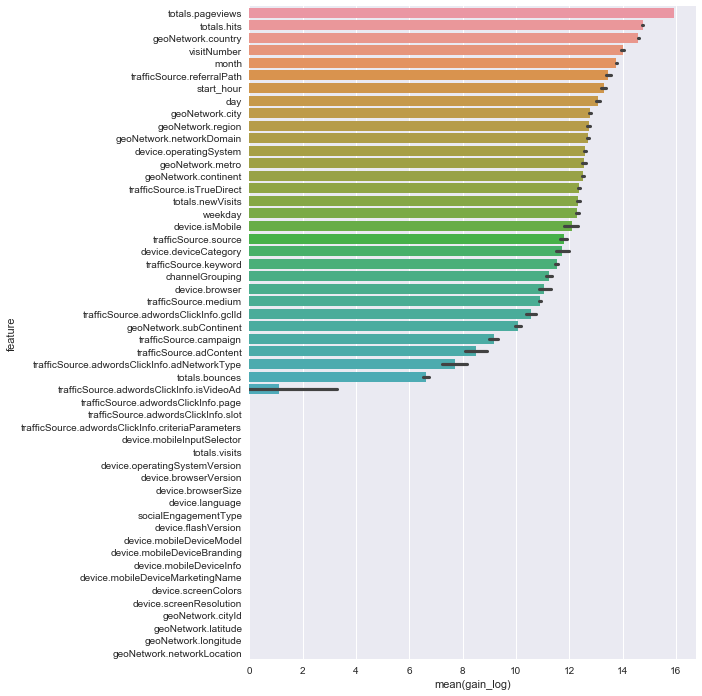

In [26]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False)[:200])

In [27]:
#SAve result 
sess_res_df = pd.DataFrame({"fullVisitorId":df_test['fullVisitorId']})

sess_res_df["PredictedLogRevenue"] = sub_reg_preds
sess_res_df = sess_res_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sess_res_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sess_res_df["PredictedLogRevenue"] = np.log1p(sess_res_df["PredictedLogRevenue"])
sess_res_df.to_csv("solutions/29_10_folds_models_simple.csv", index=False)

In [12]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("solutions/01_11_old_without_month.csv", index=False)

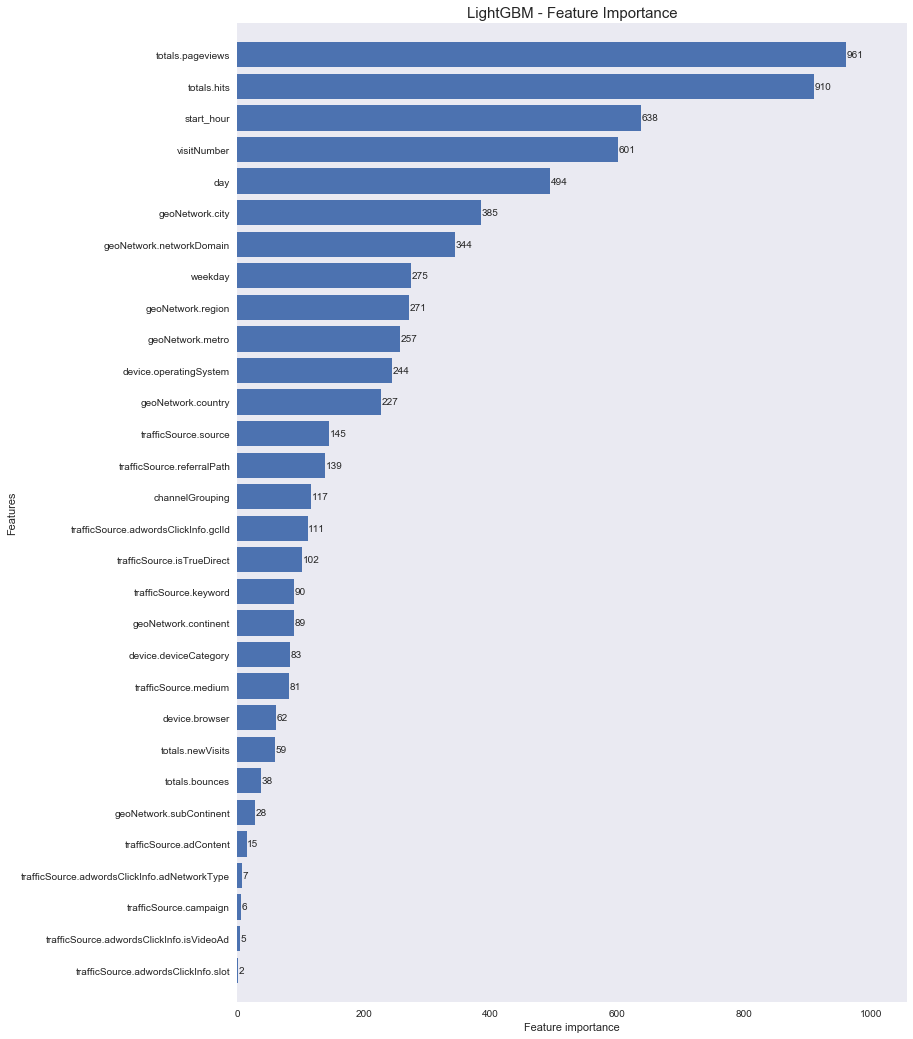

In [11]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model, max_num_features=60, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [33]:
pd.Series(lgb_model.feature_importance(),index=lgb_model.feature_name()).sort_values()

trafficSource.adwordsClickInfo.isVideoAd           0
trafficSource.adwordsClickInfo.slot                0
trafficSource.adwordsClickInfo.adNetworkType       1
trafficSource.campaign                             2
trafficSource.adwordsClickInfo.page                2
trafficSource.adwordsClickInfo.gclId               4
trafficSource.adContent                            6
geoNetwork.continent                              38
device.browser                                    73
device.deviceCategory                             84
trafficSource.keyword                             88
trafficSource.medium                              99
geoNetwork.subContinent                          112
totals.newVisits                                 147
trafficSource.isTrueDirect                       162
totals.bounces                                   164
channelGrouping                                  189
trafficSource.referralPath                       228
geoNetwork.region                             

In [46]:
combined_cols

['month-day',
 'month-weekday',
 'month-start_hour',
 'day-weekday',
 'day-start_hour',
 'weekday-start_hour',
 'month-day-weekday',
 'month-day-start_hour',
 'month-weekday-start_hour',
 'day-weekday-start_hour']

In [26]:
df_train[num_cols].describe()

,totals.hits,totals.pageviews,visitNumber,visitStartTime,totals.bounces,totals.newVisits
count,903653.000000,903553.000000,903653.000000,9.036530e+05,450630.0,703060.0
mean,4.596538,3.849764,2.264897,1.485007e+09,1.0,1.0
std,9.641437,7.025274,9.283735,9.022124e+06,0.0,0.0
min,1.000000,1.000000,1.000000,1.470035e+09,1.0,1.0
25%,1.000000,1.000000,1.000000,1.477561e+09,1.0,1.0
50%,2.000000,1.000000,1.000000,1.483949e+09,1.0,1.0
75%,4.000000,4.000000,1.000000,1.492759e+09,1.0,1.0
max,500.000000,469.000000,395.000000,1.501657e+09,1.0,1.0


In [132]:
for col in dev_X.columns:
    if dev_X[col].isnull().any():
        print(col)

totals.bounces
totals.newVisits


In [158]:
ohe=OneHotEncoder(categorical_features='all')
fit_ohe=ohe.fit(pd.concat([dev_X,val_X])[cat_cols])
o_dev_X=fit_ohe.transform(dev_X[cat_cols])
o_val_X=fit_ohe.transform(val_X[cat_cols])

In [153]:
o_dev_X[:,:3].toarray()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

In [133]:
cat_cols_ind=[]
for col in cat_cols:
    cat_cols_ind.append(list(dev_X.columns).index(col))
cat_cols_ind  

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

In [230]:
start_time=pd.to_datetime(df_train['visitStartTime'],unit='s')

122

In [272]:

dev_X.head(15)


,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect,totals.hits,totals.pageviews,visitNumber,visitStartTime,totals.bounces,totals.newVisits,month,day,weekday,start_hour,start_minute,start_second,day_seconds,month_seconds,week_seconds
0,4,35,0,20,378,3,210,0,37454,193,21,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472830e+09,1.0,1.0,9,2,4,15,33,5,55985,228785,487985
1,4,43,0,7,955,5,12,122,10098,482,1,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472880e+09,1.0,1.0,9,2,4,5,22,27,19347,278547,537747
2,4,35,0,20,475,4,185,0,38725,99,19,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472865e+09,1.0,1.0,9,2,4,1,16,26,4586,263786,522986
3,4,79,0,6,955,3,94,122,38725,482,16,62,3,59008,11,3,4,1607,5,3196,208,1,1,1.0,1.0,1.0,1.472881e+09,1.0,1.0,9,2,4,5,40,13,20413,279613,538813
4,4,35,1,1,955,4,217,122,38725,482,13,62,3,59008,11,3,4,11,5,3196,208,1,0,1.0,1.0,2.0,1.472823e+09,1.0,NaN,9,2,4,13,23,20,48200,221000,480200
5,4,35,0,20,955,4,100,122,12548,482,19,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472807e+09,1.0,1.0,9,2,4,9,6,34,32794,205594,464794
6,4,35,0,20,955,3,154,122,38725,482,18,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472817e+09,1.0,1.0,9,2,4,11,54,1,42841,215641,474841
7,4,35,0,20,125,5,12,0,4340,339,1,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472813e+09,1.0,1.0,9,2,4,10,36,42,38202,211002,470202
8,4,47,0,20,955,4,13,122,33822,482,22,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472806e+09,1.0,1.0,9,2,4,8,43,4,31384,204184,463384
9,4,43,0,20,955,4,144,122,6636,482,22,62,3,59008,11,3,4,11,5,3196,208,1,1,1.0,1.0,1.0,1.472812e+09,1.0,1.0,9,2,4,10,31,12,37872,210672,469872


PeriodIndex(['2000-03-31 00:00', '2000-05-31 00:00', '2000-08-31 00:00'], dtype='period[H]', freq='H')